In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc

np.random.seed(1234)
tf.set_random_seed(1234)

print(tf.__version__)

C:\Users\charl\anaconda3\envs\tf114\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\charl\anaconda3\envs\tf114\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\charl\anaconda3\envs\tf114\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\charl\anaconda3\envs\tf114\lib\site-packages\tensorflow\python\f

1.14.0


C:\Users\charl\anaconda3\envs\tf114\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub):
        
        ####################################################        
        ############ explanation of parameters #############
        #    x0: x coordinates of the training data points at t=0
        #    u0: training data u at x0 and t=0
        #    v0: training data v at x0 and t=0
        #    tb: t coordinates of the collocation points at x=-5, x=5    
        #    X_f: (x,t) coordinates of the collocation points
        #    layers: [# of neurons in input, # of neurons in hidden layer1, ..., # of neurons in output]
        #    lb: (x,t) coordinates of the lower-left corner
        #    ub: (x,t) coordinates of the upper-right corner
        ####################################################

        X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)  (x,t=0) cordinates of the training data at t=0
        X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb) (x,t) cordinates of the training data at the lower boundary x=-5
        X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb) (x,t) cordinates of the training data at the upper boundary x=5
        
        self.lb = lb # (x,t) coordinate of the lower-left corner
        self.ub = ub # (x,t) coordinate of the upper-right corner
               
        self.x0 = X0[:,0:1] # x cordinates of the training data at the left boundary t=0 
        self.t0 = X0[:,1:2] # t cordinates of the training data at the left boundary t=0

        self.x_lb = X_lb[:,0:1] # x cordinates of the collocation points at the lower boundary x=-5 
        self.t_lb = X_lb[:,1:2] # t cordinates of the collocation points at the lower boundary x=-5 

        self.x_ub = X_ub[:,0:1] # x cordinates of the collocation points at the upper boundary x=5 
        self.t_ub = X_ub[:,1:2] # t cordinates of the collocation points at the upper boundary x=5 
        
        self.x_f = X_f[:,0:1] # x coordinate of the collocation points
        self.t_f = X_f[:,1:2] # t coordinate of the collocation points
        
        self.u0 = u0 # training data u at x0 and t=0
        self.v0 = v0 # training data v at x0 and t=0
        
        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders        
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        # tf Graphs
        self.u0_pred, self.v0_pred, _ , _ = self.net_uv(self.x0_tf, self.t0_tf)
        self.u_lb_pred, self.v_lb_pred, self.u_x_lb_pred, self.v_x_lb_pred = self.net_uv(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred, self.v_ub_pred, self.u_x_ub_pred, self.v_x_ub_pred = self.net_uv(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred, self.f_v_pred = self.net_f_uv(self.x_f_tf, self.t_f_tf)
        
        # Loss (boundary conditions and equation loss)
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred)) + \
                    tf.reduce_mean(tf.square(self.u_lb_pred - self.u_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_lb_pred - self.v_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.u_x_lb_pred - self.u_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_x_lb_pred - self.v_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_v_pred))
        
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 30,  # original maxiter 50000
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        # A method to intialize the NN weights
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        # A fully connected NN with input X and output Y
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_uv(self, x, t):
        # given x,t, use NN output to calculate du/dx, dv/dx
        X = tf.concat([x,t],1)  # NN input
        
        uv = self.neural_net(X, self.weights, self.biases)
        u = uv[:,0:1]  # NN output u
        v = uv[:,1:2]  # NN output v
        
        u_x = tf.gradients(u, x)[0] #du/dx derivative of output wrt input
        v_x = tf.gradients(v, x)[0] #dv/dx derivative of output wrt input

        return u, v, u_x, v_x

    def net_f_uv(self, x, t):
        # given x,t, use NN output to calculate du/dt, dv/dt, d^2u/dx^2, d^2v/dx^2, and f
        u, v, u_x, v_x = self.net_uv(x,t)
        
        u_t = tf.gradients(u, t)[0] 
        u_xx = tf.gradients(u_x, x)[0]
        
        v_t = tf.gradients(v, t)[0]
        v_xx = tf.gradients(v_x, x)[0]
        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u   
        
        return f_u, f_v
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self, nIter):
        # nIter: number of iterations
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.u0_tf: self.u0, self.v0_tf: self.v0,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:         # print every 10 iterations
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
        # PINN prediction and eqn loss f at the (x,t) coordinates in X_star
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        v_star = self.sess.run(self.v0_pred, tf_dict)  
        
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred, tf_dict)
               
        return u_star, v_star, f_u_star, f_v_star
    


In [3]:
if __name__ == "__main__": 
     
    noise = 0.0        
    
    # Doman bounds
    lb = np.array([-5.0, 0.0])     # (x,t) coordinate of the lower-left corner
    ub = np.array([5.0, np.pi/2])  # (x,t) coordinate of the upper-right corner

    N0 = 50     # number of data points at t=0
    N_b = 50    # number of collocation points at upper and lower boundaries
    N_f = 20000 # number of collocation points
    layers = [2, 100, 100, 100, 100, 2]
        
    data = scipy.io.loadmat('../Data/NLS.mat')  # load training data
    
    t = data['tt'].flatten()[:,None] # t in the loaded data; a vector ranging from 0 to pi/2 
    x = data['x'].flatten()[:,None]  # x in the loaded data; a vector ranging from -5 to 5
    Exact = data['uu']
    Exact_u = np.real(Exact)         # u values on the x-t mesh; matrix of size [length of x, length of t]
    Exact_v = np.imag(Exact)         # v values on the x-t mesh; matrix of size [length of x, length of t]
    Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)
    
    X, T = np.meshgrid(x,t) # X, T are matrices of size [length of t, length of x] containing the x, t values on the x-t mesh, respectively
    
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) # x and t values of the x-t mesh, flattened into vectors
    u_star = Exact_u.T.flatten()[:,None]                           # u values on the x-t mesh, flattened into a vector
    v_star = Exact_v.T.flatten()[:,None]                           # v values on the x-t mesh, flattened into a vector
    h_star = Exact_h.T.flatten()[:,None]                           # h values on the x-t mesh, flattened into a vector
    
    ###########################
    
    idx_x = np.random.choice(x.shape[0], N0, replace=False) # randomely select N0 points in x; Generate a random sample from np.arange(x.shape[0]) of size N_0 without replacement
    x0 = x[idx_x,:]         # x coordinate of the training data points at t=0
    u0 = Exact_u[idx_x,0:1] # training data u at x0 and t=0
    v0 = Exact_v[idx_x,0:1] # training data v at x0 and t=0
    
    idx_t = np.random.choice(t.shape[0], N_b, replace=False) # randomely select N_b points in t
    tb = t[idx_t,:]         # t coordinate of the collocation points at x=-5, x=5
    
    X_f = lb + (ub-lb)*lhs(2, N_f)  # (x,t) coordinate of the collocation points
            
    model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub)
             
    start_time = time.time()                
    model.train(2000)  # original niter is 200000
    elapsed = time.time() - start_time                
    print('Training time: %.4f' % (elapsed))
    
        
    u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star) # make prediction on the full x-t mesh (e.g. X_star)
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
    
    # compare the difference between prediction and ground truth from the data on the full x-t mesh (e.g. X_star)
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
    error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)
    print('Error u: %e' % (error_u))
    print('Error v: %e' % (error_v))
    print('Error h: %e' % (error_h))

    # reshape flatterned data
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
    H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')

    FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
    FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')     
    

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
It: 0, Loss: 7.274e-01, Time: 2.34
It: 10, Loss: 5.386e-01, Time: 2.58
It: 20, Loss: 4.618e-01, Time: 2.63
It: 30, Loss: 4.528e-01, Time: 2.78
It: 40, Loss: 4.411e-01, Time: 2.84
It: 50, Loss: 4.317e-01, Time: 3.26
It: 60, Loss: 4.104e-01, Time: 3.46
It: 70, Loss: 3.751e-01, Time: 3.45
It: 80, Loss: 3.260e-01, Time: 3.44
It: 90, Loss: 2.706e-01, Time: 3.45
It: 100, Loss: 2.063e-01, Time: 3.45
It: 110, Loss: 1.701e-01, Time: 7.05
It: 120, Loss: 1.555e-01, Time: 10.96
It: 130, Loss: 1.470e-01, Time: 10.96
It: 140, Loss: 1.371e-01, Time: 1

It: 1990, Loss: 2.127e-02, Time: 6.24
Loss: 0.018588841
Loss: 22785.896
Loss: 47.177753
Loss: 0.051186193
Loss: 0.01701009
Loss: 0.01700475
Loss: 0.017000291
Loss: 0.016988134
Loss: 0.01696785
Loss: 0.016940441
Loss: 0.01698735
Loss: 0.01693461
Loss: 0.016923074
Loss: 0.016919758
Loss: 0.016916981
Loss: 0.016911129
Loss: 0.016900774
Loss: 0.016918795
Loss: 0.016896546
Loss: 0.016887011
Loss: 0.016879652
Loss: 0.01687213
Loss: 0.016861152
Loss: 0.016841764
Loss: 0.016811559
Loss: 0.01677057
Loss: 0.016738726
Loss: 0.016712658
Loss: 0.016666856
Loss: 0.016553087
Loss: 0.016363386
Loss: 0.016150922
Loss: 0.01598596
Loss: 0.015875919
Loss: 0.015815355
Loss: 0.015711883
INFO:tensorflow:Optimization terminated with:
  Message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  Objective function value: 0.015712
  Number of iterations: 30
  Number of functions evaluations: 36
Training time: 1514.5527
Error u: 1.141440e+00
Error v: 1.207758e+00
Error h: 3.057019e-01


Text(0.5, 1.0, '$t = 0.98$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


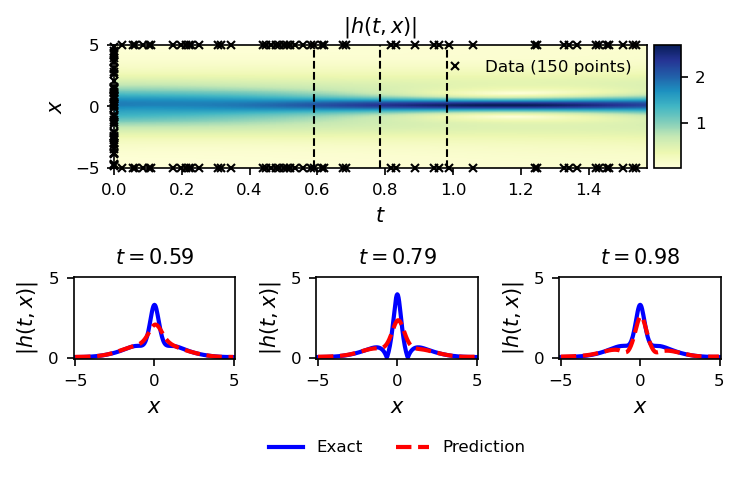

In [4]:
%matplotlib inline

rc('text', usetex=False)
plt.rcParams['figure.dpi'] = 150

######################################################################
############################# Plotting ###############################
######################################################################    

X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)  (x,t=0) cordinates of the training data at t=0
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb) (x,t) cordinates of the collocation points at the lower boundary 
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb) (x,t) cordinates of the collocation points at the upper boundary
X_u_train = np.vstack([X0, X_lb, X_ub]) # stack the (x,t) coordinates of all training data; size [N0, 2]

fig, ax = newfig(1.0, 0.9)
ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

# plot PINN prediction of h on the full x-t mesh (e.g. X_star)
h = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# plot training data (x,t) locations
ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[75]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[100]*np.ones((2,1)), line, 'k--', linewidth = 1)
ax.plot(t[125]*np.ones((2,1)), line, 'k--', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
leg = ax.legend(frameon=False, loc = 'best')
#     plt.setp(leg.get_texts(), color='w')
ax.set_title('$|h(t,x)|$', fontsize = 10)

####### Row 1: h(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact_h[:,75], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')    
ax.set_title('$t = %.2f$' % (t[75]), fontsize = 10)
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact_h[:,100], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[100,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])
ax.set_title('$t = %.2f$' % (t[100]), fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact_h[:,125], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,H_pred[125,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$|h(t,x)|$')
ax.axis('square')
ax.set_xlim([-5.1,5.1])
ax.set_ylim([-0.1,5.1])    
ax.set_title('$t = %.2f$' % (t[125]), fontsize = 10)

# savefig('./figures/NLS')  